In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import xarray as xr

from tqdm.notebook import tqdm
pd.set_option('mode.chained_assignment', None)

# WUE on eddy-covariance data (with validation) 2016-2020

This exercise has the following parts:
1. Computation of dry-matter-productivity-based water use efficiency (WUE_DMP) from eddy-covariance flux product
2. Approximation of yield with harvest index (HI) and computation of water use efficiency (WUE) (aka crop water productivity, CWP)
3. Simulation of dry-matter productivity with light use efficiency (LUE) model and Sentinel-2 normalized difference vegetation index (NDVI)
4. Scaling of Landsat-8-based evapotranspiration (ET) simulated with the two-source energy balance (TSEB) from instantaneous to seasonal values
5. Computation of the Earth-Observation-based WUE

# Data for this exercise 

FR-Lam is an ICOS eddy covariance site, flux data from 2016 until 2020 were downloaded from Warm Winter 2020 dataset (https://doi.org/10.18160/2G60-ZHAK).

Data acquisition at FR-Aur and FR-Lam are mainly funded by the Institut National des Sciences de l’Univers (INSU) through the ICOS ERIC and the OSR SW observatory (https://osr.cesbio.cnrs.fr/). Facilities and staff are funded and supported by the Observatory Midi-Pyrenean, the University Paul Sabatier of Toulouse 3, CNRS (Centre National de la Recherche Scientifique), CNES (Centre National d’Etude Spatial) and IRD (Institut de Recherche pour le Développement). We are grateful to Franck Granouillac, Baptiste Lemaire, Nicole Claverie and Bartosz Zawilski for their technical support, advice, and valuable assistance in the field and site management, respectively. We also thank Tiphaine Tallec and Aurore Brut for the data processing. Special thanks to Mr. Andréoni (farmer) and Ecole d'Ingénieurs Purpan and farmers for accommodating the measurement devices.

The PI, Aurore Brut, provided the information about the planting and harvest dates and the croptype (*FR_Lam_dates.csv*)


In [2]:
data_path = Path('1-wue-france-data')

# 1. Computation of dry-matter-productivity-based water use efficiency (WUE_DMP) from eddy-covariance flux product

This exercise is based on daily **average** data (DD files) => first thing we do is the conversion to daily **sums**

In [3]:
df = pd.read_csv(data_path / 'FR-Lam_DD.csv', index_col='date', parse_dates=True)
df.loc['2017-03-01':'2017-06-01', 'LE_F_MDS'] = np.nan  # some quality issues

df['dmp_24'] = df.GPP_NT_VUT_USTAR50 * (24*60*60) * (12+2+16) * 1e-6 * 1e-3 * 1e4 * 0.5  # kg DM ha-1 day-1
df['et_24'] = df.LE_F_MDS * 0.035  # mm day-1

Reading field data

In [4]:
df_dates = pd.read_csv(data_path / 'FR-Lam_dates.csv')
df_dates['planting'] = pd.to_datetime(df_dates['planting'], format='%d-%m-%y')
df_dates['harvesting'] = pd.to_datetime(df_dates['harvesting'], format='%d-%m-%y')
df_dates['los'] = (df_dates.harvesting - df_dates.planting).dt.days
df_dates

,Plot ID,Site name,Area (ha),Season,crop,planting,harvesting,los
0,LAM,Lamasquère,24,2014-2015,Irrigated corn,2015-05-05,2015-09-08,126
1,LAM,Lamasquère,24,2015-2016,Wheat,2015-10-20,2016-07-20,274
2,LAM,Lamasquère,24,2015-2016,White mustard+Vetch,2016-08-17,2016-11-16,91
3,LAM,Lamasquère,24,2016-2017,Irrigated corn,2017-04-28,2017-09-05,130
4,LAM,Lamasquère,24,2017-2018,winter Wheat,2017-11-16,2018-07-10,236
5,LAM,Lamasquère,24,2018-2019,Irrigated corn,2019-04-22,2019-09-09,140
6,LAM,Lamasquère,24,2019-2020,winter Wheat,2019-10-19,2020-07-03,258


Plotting

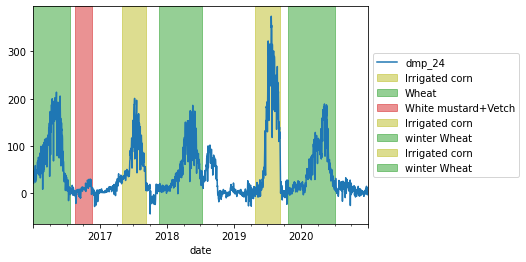

In [5]:
ax = df.dmp_24.plot()

for _, row in df_dates.iterrows():
    color = 'tab:green'
    if 'corn' in row.crop:
        color = 'tab:olive'
    elif 'Vetch' in row.crop:
        color = 'tab:red'
    
    ax.axvspan(row.planting, row.harvesting, color=color, alpha=0.5, label=row.crop)
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Q: do the declared seasons coincide with the peaks in photosynthesis?

Computing WUE_DMP

$WUE_{DMP} \ \text{[kg mm-1 ha-1]} = \dfrac{DMP_{season}}{ET_{season}}$

In [6]:
for i, row in df_dates.iterrows():
    df_dates.loc[i, 'dmp_sum'] = df.loc[row.planting:row.harvesting, 'dmp_24'].sum()
    df_dates.loc[i, 'et_sum'] = df.loc[row.planting:row.harvesting, 'et_24'].sum()

df_dates['wue_dmp'] = df_dates.dmp_sum / df_dates.et_sum
df_dates

,Plot ID,Site name,Area (ha),Season,crop,planting,harvesting,los,dmp_sum,et_sum,wue_dmp
0,LAM,Lamasquère,24,2014-2015,Irrigated corn,2015-05-05,2015-09-08,126,0.000000,0.000000,NaN
1,LAM,Lamasquère,24,2015-2016,Wheat,2015-10-20,2016-07-20,274,18520.225819,483.582059,38.298000
2,LAM,Lamasquère,24,2015-2016,White mustard+Vetch,2016-08-17,2016-11-16,91,858.693106,110.192943,7.792632
3,LAM,Lamasquère,24,2016-2017,Irrigated corn,2017-04-28,2017-09-05,130,10753.378819,221.507608,48.546318
4,LAM,Lamasquère,24,2017-2018,winter Wheat,2017-11-16,2018-07-10,236,13655.620142,266.338612,51.271650
5,LAM,Lamasquère,24,2018-2019,Irrigated corn,2019-04-22,2019-09-09,140,19282.141457,297.150662,64.890118
6,LAM,Lamasquère,24,2019-2020,winter Wheat,2019-10-19,2020-07-03,258,14257.623345,256.637044,55.555594


# 2.Approximation of yield with harvest index (HI) and computation of water use efficiency (WUE) (aka crop water productivity, CWP)

$yield\ \text{[kg FW ha-1]} = \dfrac{DMP * f\_agb * HI} {(1 - \theta)}$

- DMP - dry matter productivity
- f_agb - above-ground-biomass fraction
- HI - harvest index (dry weight of the harvestable material / total aboveground biomass)
- $\theta$ - moisture content of the harvestable material

In [7]:
# wheat
f_agb = 0.86  # from FAO
hi = 0.50 # -
theta = 0.15  # g DW g-1 FW

df_dates['yield'] = df_dates.dmp_sum * f_agb * hi / (1 - theta)
df_dates.loc[df_dates.crop.str.contains('corn'), 'yield'] = df_dates.dmp_sum * 0.90 * 0.55 / (1 - 0.26)  # maize

df_dates['wue'] = df_dates['yield'] / df_dates['et_sum']  # kg ha-1 mm-1
df_dates

,Plot ID,Site name,Area (ha),Season,crop,planting,harvesting,los,dmp_sum,et_sum,wue_dmp,yield,wue
0,LAM,Lamasquère,24,2014-2015,Irrigated corn,2015-05-05,2015-09-08,126,0.000000,0.000000,NaN,0.000000,NaN
1,LAM,Lamasquère,24,2015-2016,Wheat,2015-10-20,2016-07-20,274,18520.225819,483.582059,38.298000,9369.055414,19.374282
2,LAM,Lamasquère,24,2015-2016,White mustard+Vetch,2016-08-17,2016-11-16,91,858.693106,110.192943,7.792632,434.397689,3.942155
3,LAM,Lamasquère,24,2016-2017,Irrigated corn,2017-04-28,2017-09-05,130,10753.378819,221.507608,48.546318,7193.138534,32.473551
4,LAM,Lamasquère,24,2017-2018,winter Wheat,2017-11-16,2018-07-10,236,13655.620142,266.338612,51.271650,6908.137248,25.937423
5,LAM,Lamasquère,24,2018-2019,Irrigated corn,2019-04-22,2019-09-09,140,19282.141457,297.150662,64.890118,12898.189218,43.406228
6,LAM,Lamasquère,24,2019-2020,winter Wheat,2019-10-19,2020-07-03,258,14257.623345,256.637044,55.555594,7212.680045,28.104594


# Q: is this WUE anywhere near the literature values for corn and wheat?

# 3. Simulation of dry-matter productivity with light use efficiency (LUE) model and Sentinel-2 normalized difference vegetation index (NDVI)

$ GPP \ \text{[g C m-2 day-1]} = LUE_{MAX} * f(Ta) * f(VPD) * fpar * (SW\_IN * 0.45) $

- lue_max - light use efficiency, g C MJ-1
- f(Ta) - air temperature dependence (stress function, 0 => stress, 1 => ok)
- f(VPD) - vapour pressure deficit dependence (stress function, 0 => stress, 1 => ok)
- fpar - fraction of absorbed photosynthetically active radiation
- (SW_IN * 0.45) - photosynthetically active radiation (PAR) accumulated over the day, 45% of total incoming radiation

The values of parameters are from He et al., 2018 https://doi.org/10.3390/rs10030372

reading NDVI and making it daily

NDVI is from Sentinel-2 HR-VPP project https://land.copernicus.eu/pan-european/biophysical-parameters/high-resolution-vegetation-phenology-and-productivity downloaded through WEkEO Copernicus DIAS and aggregated to field level

In [8]:
df_ndvi = pd.read_csv(data_path / 'FR-Lam_NDVI.csv', index_col=0, parse_dates=True)

linear interpolation is a bit jumpy

<AxesSubplot:xlabel='date'>

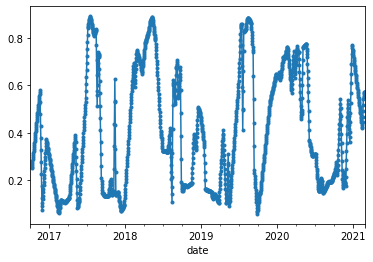

In [9]:
df_ndvi.NDVI_median.resample('D').mean().interpolate().plot(style='.-')

moving average is also a bit jumpy

<AxesSubplot:xlabel='date'>

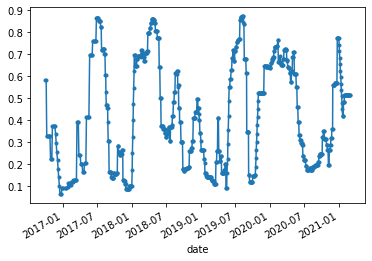

In [10]:
df_ndvi.NDVI_median.rolling('30D').mean().shift(-15).interpolate().plot(style='.-')

<AxesSubplot:xlabel='date'>

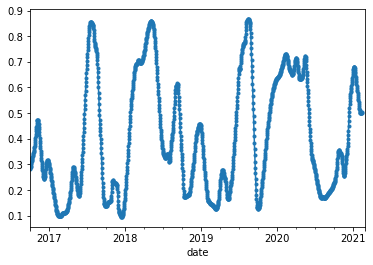

In [11]:
df_ndvi.NDVI_median.resample('D').mean().interpolate().rolling('30D').mean().shift(-15).plot(style='.-')

NDVI -> fpar

<AxesSubplot:xlabel='date'>

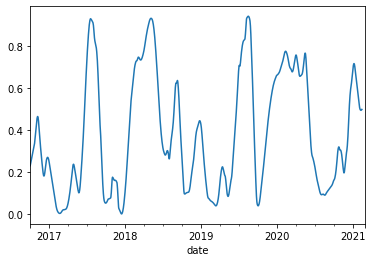

In [12]:
ndvi = df_ndvi.NDVI_median.resample('D').mean().interpolate().rolling('30D').mean().shift(-15)

ndvi_max = ndvi.max()
ndvi_min = ndvi.min()

fpar_max = 0.95
fpar_min = 0.01

fpar = (ndvi - ndvi_min) / (ndvi_max - ndvi_min) * (fpar_max - fpar_min)
fpar.plot()

stress factors

In [13]:
lue_max = 2.55  # gC MJ-1
vpd_max = 6940  # Pa
vpd_min = 1  # Pa
ta_max = 45.85  # C
ta_min = -23.15  # C

df['ta_stress'] = (df.TA_F - ta_min)/(ta_max - ta_min)
df.loc[df.TA_F > ta_max, 'ta_stress'] = 1
df.loc[df.TA_F < ta_min, 'ta_stress'] = 0


df['vpd_stress'] = (vpd_max - df.VPD_F)/(vpd_max - vpd_min)
df.loc[df.VPD_F > vpd_max, 'vpd_stress'] = 0
df.loc[df.VPD_F < vpd_min, 'vpd_stress'] = 1

In [14]:
df = df.join(fpar)

<AxesSubplot:xlabel='date'>

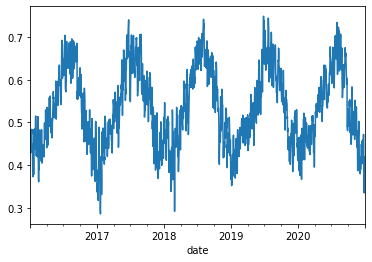

In [15]:
df.ta_stress.plot()

<AxesSubplot:xlabel='date'>

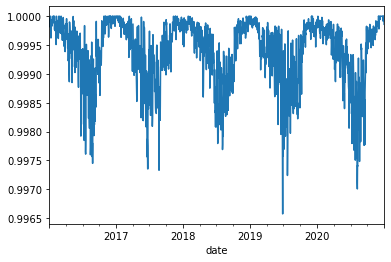

In [16]:
df.vpd_stress.plot()

# Q: Which parameter (in this model realization) affects photosynthesis stronger Ta or VPD?

computation of GPP

In [17]:
df['gpp'] = lue_max * df.ta_stress * df.vpd_stress * fpar * df.SW_IN_F * (60*60*24 * 1e-6) * 0.45 # gC m-2 day-1

In [18]:
df['gpp_umol'] = lue_max * df.ta_stress * df.vpd_stress * fpar * df.SW_IN_F * 0.45 / 12 # umolCO2 m-2 s-1

validation looks terrific, taken that no fitting was applied, pure values from the paper

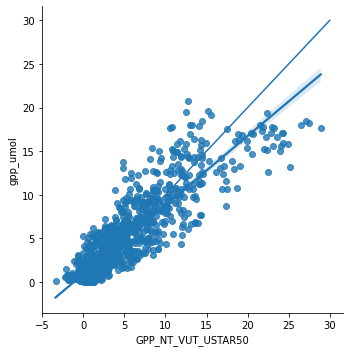

In [19]:
g = sns.lmplot(data=df, x='GPP_NT_VUT_USTAR50', y='gpp_umol')
lims = [0, 30]
g.axes.flatten()[0].plot(lims, lims)

<AxesSubplot:xlabel='date'>

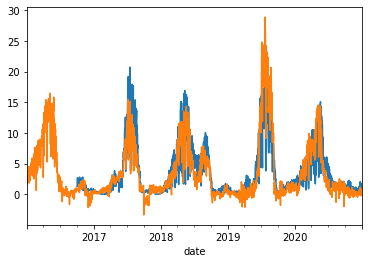

In [20]:
df.gpp_umol.plot()
df.GPP_NT_VUT_USTAR50.plot()

# Q1: Can you compute the metrics for the fit: R2, RMSE, bias?

# Q2*: Can you suggest reparamerization of the LUE to improve the fit?

# 4. Scaling of Landsat-8-based evapotranspiration (ET) simulated with the two-source energy balance (TSEB) from instantaneous to seasonal values

TSEB model was explained to you on Tuesday

There is a Google Earth Engine version of it that runs on Landsat images: https://code.earthengine.google.com/7c5e894582547f0a67e2bcccbd964a7a?noload=true

The resulting images are in the folder *GEE_esa_fr*

The model returns instantaneous (at the time of satellite overpass) latent heat flux (LE)

We are going to scale it to daily ET and further to fill the gaps in between satellite overpasses based on net radiation and evaporative fraction (EF)

## what is in the image

- bands of Landsat surface reflectance (SR_*), surface temperature (ST_*), quality flags
    - computed NDVI, albedo, radiometric temperature, LAI
- ERA5 meteorological data at the time of overpass
    - radiation, temperature, wind speed
- TSEB computed values
    - soil, canopy and scene temperature, net radiation, instantaneous heat fluxes

In [21]:
tif = xr.open_dataset(data_path / 'GEE_esa_fr' / '1_2_LC08_198030_20190814_20190814T10.tif')
tif

<xarray.Dataset>
Dimensions:      (band: 55, x: 20, y: 22)
Coordinates:
  * band         (band) int32 1 2 3 4 5 6 7 8 9 ... 47 48 49 50 51 52 53 54 55
  * x            (x) float64 3.572e+05 3.573e+05 ... 3.578e+05 3.578e+05
  * y            (y) float64 4.818e+06 4.818e+06 ... 4.817e+06 4.817e+06
    spatial_ref  int32 ...
Data variables:
    band_data    (band, y, x) float32 ...

In [22]:
band_names = tif.band_data.attrs['long_name']
tif.band_data.attrs['long_name'] = []
band_names

('SR_B1',
 'SR_B2',
 'SR_B3',
 'SR_B4',
 'SR_B5',
 'SR_B6',
 'SR_B7',
 'SR_QA_AEROSOL',
 'ST_B10',
 'ST_ATRAN',
 'ST_CDIST',
 'ST_DRAD',
 'ST_EMIS',
 'ST_EMSD',
 'ST_QA',
 'ST_TRAD',
 'ST_URAD',
 'QA_PIXEL',
 'QA_RADSAT',
 'albedo',
 'albedo_vis',
 'albedo_nir',
 'NDVI',
 'radiometric_temperature',
 'LAI',
 'surface_pressure',
 'air_temperature',
 'u_component_of_wind_10m',
 'v_component_of_wind_10m',
 'surface_solar_radiation_downwards_hourly',
 'surface_thermal_radiation_downwards_hourly',
 'wind_speed',
 'solar_radiation',
 'thermal_radiation',
 'Tc',
 'Ts',
 'Tac',
 'Hc',
 'Hs',
 'LEc',
 'LEs',
 'Ra',
 'Rs',
 'Rx',
 'Ustar',
 'alphaPT',
 'iteration',
 'LE',
 'H',
 'G',
 'Rn',
 'Rns',
 'Rnc',
 'ETd',
 'EF')

In [23]:
band_names.index('Rn'), band_names.index('G'), band_names.index('LE'), band_names.index('surface_solar_radiation_downwards_hourly')

(50, 49, 47, 29)

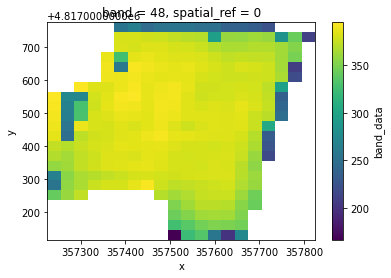

In [24]:
tif.sel(band=48).band_data.plot()

reading images in a loop

In [25]:
df_path = pd.DataFrame({'path': (data_path / 'GEE_esa_fr').glob('*.tif')})
df_path['date'] = df_path.path.apply(lambda row: pd.to_datetime(row.name.split('_')[-1].replace('T10.tif', '')))
df_path = df_path.sort_values('date')
df_path.head(7)

,path,date
0,1-wue-france-data\GEE_esa_fr\1_2_LC08_198030_2...,2015-12-09
1,1-wue-france-data\GEE_esa_fr\1_2_LC08_198030_2...,2015-12-25
2,1-wue-france-data\GEE_esa_fr\1_2_LC08_198030_2...,2016-01-10
3,1-wue-france-data\GEE_esa_fr\1_2_LC08_198030_2...,2016-01-26
4,1-wue-france-data\GEE_esa_fr\1_2_LC08_198030_2...,2016-02-27
5,1-wue-france-data\GEE_esa_fr\1_2_LC08_198030_2...,2016-03-14
6,1-wue-france-data\GEE_esa_fr\1_2_LC08_198030_2...,2016-03-30


In [26]:
date_val = []

for _, row in tqdm(list(df_path.iterrows()), 'tiffs'):
    tif = xr.open_dataset(row.path)
    tif.band_data.attrs = dict()
    
    ef = tif.sel(band=48) / (tif.sel(band=51) - tif.sel(band=50))
    swf = tif.sel(band=48) / (tif.sel(band=30) / (60*60))
    
    # break
    res_i = {
        'date': row.date, 
        'EF': ef.band_data.mean().values,
        'SWF': swf.band_data.mean().values 
    }
    
    date_val.append(res_i)
    

tiffs:   0%|          | 0/111 [00:00<?, ?it/s]

<AxesSubplot:xlabel='date'>

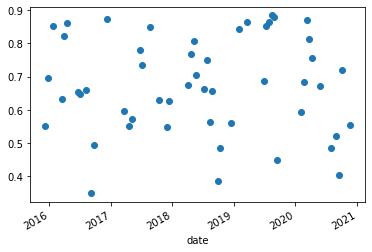

In [27]:
df_ef = pd.DataFrame(date_val).set_index('date').astype(float) 
df_ef = df_ef[df_ef.EF < 1] 
df_ef.EF.plot(style='o')

## upscaling of instantaneous LE to daily ET

This is done on the assumption of constant ratio of LE to available energy (Rn - G, net radiation minus ground heat flux) throughout a day

$\dfrac{LE_{inst}}{(RN_{inst} - G_{inst})} \approx \dfrac{LE_{24}}{(RN_{24} - G_{24})} $

In [28]:
df = df.join(df_ef)

In [29]:
df.columns

Index(['LAI', 'TIMESTAMP', 'SW_IN_F', 'LW_IN_F', 'PA_F', 'TA_F', 'WS_F',
       'VPD_F', 'CO2_F_MDS', 'RN', 'SW_IN_ERA', 'LW_IN_ERA', 'PA_ERA',
       'TA_ERA', 'WS_ERA', 'VPD_ERA', 'P_ERA', 'SWC_F_MDS_1', 'H_F_MDS',
       'LE_F_MDS', 'G_F_MDS', 'GPP_NT_VUT_USTAR50', 'LE_CORR', 'H_CORR',
       'SW_OUT', 'LW_OUT', 'dmp_24', 'et_24', 'ta_stress', 'vpd_stress',
       'NDVI_median', 'gpp', 'gpp_umol', 'EF', 'SWF'],
      dtype='object')

In [30]:
df['LE_ef'] = df.RN * df.EF
# df['LE_swf'] = df.SW_IN_F * df.SWF

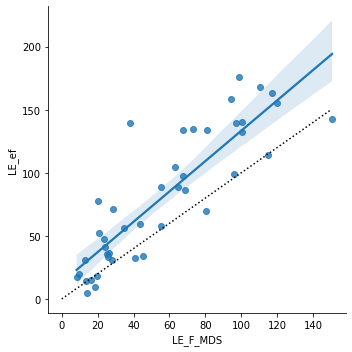

In [31]:
g = sns.lmplot(data=df, x='LE_F_MDS', y='LE_ef')
lims = [0, 150]
g.axes.flatten()[0].plot(lims, lims, 'k:')

<AxesSubplot:xlabel='date'>

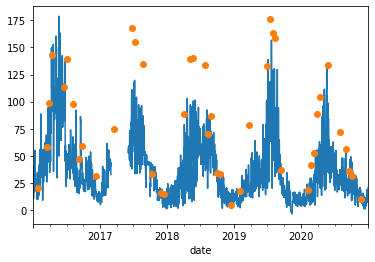

In [32]:
df.LE_F_MDS.plot()
df.LE_ef.plot(style='o')

## gap-fill ET (on the premise of EF)

In [33]:
df['LE_ef_filled'] = df.EF.interpolate() * df.RN

<AxesSubplot:xlabel='date'>

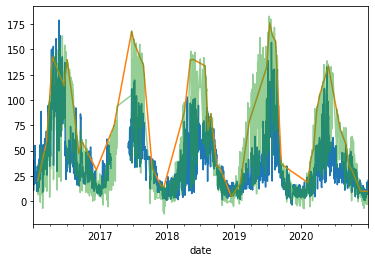

In [34]:
df.LE_F_MDS.plot()
df.LE_ef.interpolate().plot()
df.LE_ef_filled.interpolate().plot(alpha=0.5)

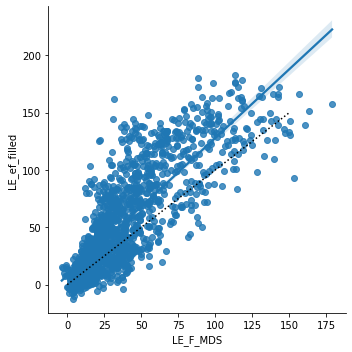

In [35]:
g = sns.lmplot(data=df, x='LE_F_MDS', y='LE_ef_filled')
lims = [0, 150]
g.axes.flatten()[0].plot(lims, lims, 'k:')

# 5. Computation of the Earth-Observation-based WUE

same as point 2 but with simulated data

In [36]:
df['dmp_lue_24'] = df.gpp_umol * (24*60*60) * (12+2+16) * 1e-6 * 1e-3 * 1e4 * 0.5  # kg DM ha-1 day-1
df['et_tseb_24'] = df.LE_ef_filled * 0.035  # mm day-1

for i, row in df_dates.iterrows():
    df_dates.loc[i, 'dmp_lue_sum'] = df.loc[row.planting:row.harvesting, 'dmp_lue_24'].sum()
    df_dates.loc[i, 'et_tseb_sum'] = df.loc[row.planting:row.harvesting, 'et_tseb_24'].sum()

df_dates['wue_dmp_eo'] = df_dates.dmp_lue_sum / df_dates.et_tseb_sum
df_dates

,Plot ID,Site name,Area (ha),Season,crop,planting,harvesting,los,dmp_sum,et_sum,wue_dmp,yield,wue,dmp_lue_sum,et_tseb_sum,wue_dmp_eo
0,LAM,Lamasquère,24,2014-2015,Irrigated corn,2015-05-05,2015-09-08,126,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000,NaN
1,LAM,Lamasquère,24,2015-2016,Wheat,2015-10-20,2016-07-20,274,18520.225819,483.582059,38.298000,9369.055414,19.374282,0.000000,487.208457,0.000000
2,LAM,Lamasquère,24,2015-2016,White mustard+Vetch,2016-08-17,2016-11-16,91,858.693106,110.192943,7.792632,434.397689,3.942155,1015.271435,121.162487,8.379421
3,LAM,Lamasquère,24,2016-2017,Irrigated corn,2017-04-28,2017-09-05,130,10753.378819,221.507608,48.546318,7193.138534,32.473551,12891.221864,254.708742,50.611619
4,LAM,Lamasquère,24,2017-2018,winter Wheat,2017-11-16,2018-07-10,236,13655.620142,266.338612,51.271650,6908.137248,25.937423,13718.514766,236.514919,58.002746
5,LAM,Lamasquère,24,2018-2019,Irrigated corn,2019-04-22,2019-09-09,140,19282.141457,297.150662,64.890118,12898.189218,43.406228,15388.654912,502.794292,30.606264
6,LAM,Lamasquère,24,2019-2020,winter Wheat,2019-10-19,2020-07-03,258,14257.623345,256.637044,55.555594,7212.680045,28.104594,13835.327378,369.777092,37.415318


the magic of an outlier ...

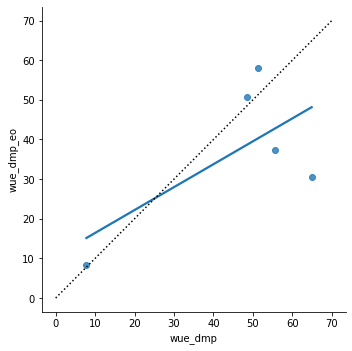

In [37]:
g = sns.lmplot(data=df_dates[df_dates.dmp_lue_sum != 0], x='wue_dmp', y='wue_dmp_eo', ci=False)
lims = [0, 70]
g.axes.flatten()[0].plot(lims, lims, 'k:')